**Customer Segmentation using RFM Analysis :**

In [1]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Customer_Master_Data.csv',
 'Customer_Master_Data.xlsx',
 'Customer_RFM_Project.ipynb',
 'Customer_Transactions.csv']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_master = pd.read_csv("Customer_Master_Data.csv")
transactions = pd.read_csv("Customer_Transactions.csv")

print(customer_master.shape)
print(transactions.shape)

customer_master.head()

(1000, 9)
(23050, 3)


,CustomerID,Name,Email,Gender,Age,City,MaritalStatus,NumChildren,JoinDate
0,CUST10000,Onkar Bhargava,pkeer@yahoo.com,Male,54,Delhi,Divorced,0,2021-02-22
1,CUST10001,Divit Kohli,mkalita@sarin.com,Female,48,Kolkata,Married,0,2023-12-06
2,CUST10002,Kiara Behl,apteanay@hotmail.com,Male,75,Kolkata,Widowed,2,2023-08-23
3,CUST10003,Vaibhav Sankar,bseshadri@choudhry.info,Male,62,Pune,Divorced,2,2022-11-17
4,CUST10004,Shray D’Alia,bdhillon@toor-mall.com,Male,55,Delhi,Divorced,0,2022-12-04


**Data Cleaning :**

In [4]:
# Convert date columns to datetime
customer_master["JoinDate"] = pd.to_datetime(customer_master["JoinDate"], errors="coerce")
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"], errors="coerce")

print(customer_master.dtypes)
print(transactions.dtypes)

C:\Users\Honey\AppData\Local\Temp\ipykernel_7328\2799794613.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"], errors="coerce")


CustomerID               object
Name                     object
Email                    object
Gender                   object
Age                       int64
City                     object
MaritalStatus            object
NumChildren               int64
JoinDate         datetime64[ns]
dtype: object
CustomerID                   object
TransactionDate      datetime64[ns]
TransactionAmount           float64
dtype: object


In [5]:
print("Missing values in Customer Master:")
print(customer_master.isna().sum())

print("\nMissing values in Transactions:")
print(transactions.isna().sum())

Missing values in Customer Master:
CustomerID       0
Name             0
Email            0
Gender           0
Age              0
City             0
MaritalStatus    0
NumChildren      0
JoinDate         0
dtype: int64

Missing values in Transactions:
CustomerID           0
TransactionDate      0
TransactionAmount    0
dtype: int64


In [6]:
print("Duplicate rows in Customer Master:", customer_master.duplicated().sum())
print("Duplicate rows in Transactions:", transactions.duplicated().sum())

Duplicate rows in Customer Master: 0
Duplicate rows in Transactions: 0


In [7]:
print("Unique CustomerIDs:", customer_master["CustomerID"].nunique())
print("Total rows:", len(customer_master))

Unique CustomerIDs: 1000
Total rows: 1000


In [8]:
missing_ids = set(transactions["CustomerID"]) - set(customer_master["CustomerID"])
print("CustomerIDs in transactions but not in master:", len(missing_ids))

CustomerIDs in transactions but not in master: 0


In [9]:
# Merge transactions with customer master data
df = transactions.merge(customer_master, on="CustomerID", how="left")

print("Merged data shape:", df.shape)
df.head()

Merged data shape: (23050, 11)


,CustomerID,TransactionDate,TransactionAmount,Name,Email,Gender,Age,City,MaritalStatus,NumChildren,JoinDate
0,CUST10771,2023-07-31,2383.07,Lakshay Dhillon,dharmajantara@gmail.com,Female,27,Ahmedabad,Widowed,3,2023-05-31
1,CUST10100,2024-03-10,497.54,Aniruddh Borah,jivikabhavsar@gmail.com,Female,53,Lucknow,Divorced,4,2022-01-08
2,CUST10031,2025-02-17,536.78,Ritvik Ahuja,jhaverifarhan@chandra.org,Male,40,Ahmedabad,Single,0,2023-12-03
3,CUST10987,2023-07-17,314.89,Jayan Wagle,ojas82@gmail.com,Not Disclosed,75,Bangalore,Widowed,4,2022-03-18
4,CUST10831,2024-12-15,2543.19,Ishita Agarwal,vbalay@yahoo.com,Not Disclosed,27,Jaipur,Divorced,4,2021-06-30


In [10]:
reference_date = df["TransactionDate"].max() + pd.Timedelta(days=1)
print("Reference Date:", reference_date)

Reference Date: 2025-07-30 00:00:00


**RFM Analysis :**

In [11]:
rfm = df.groupby("CustomerID").agg({
    "TransactionDate": lambda x: (reference_date - x.max()).days,  # Recency
    "CustomerID": "count",                                         # Frequency
    "TransactionAmount": "sum"                                      # Monetary
}).rename(columns={
    "TransactionDate": "Recency",
    "CustomerID": "Frequency",
    "TransactionAmount": "Monetary"
}).reset_index()

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,CUST10000,13,23,21265.49
1,CUST10001,35,30,28654.31
2,CUST10002,18,24,23884.03
3,CUST10003,81,25,24206.03
4,CUST10004,8,19,25565.30


In [12]:
rfm.describe()

,Recency,Frequency,Monetary
count,1000.000000,1000.000000,1000.00000
mean,50.794000,23.050000,23053.19966
std,58.124418,4.810472,5622.44101
min,1.000000,6.000000,5052.69000
25%,13.000000,20.000000,18965.46250
50%,32.000000,23.000000,22969.82000
75%,69.000000,26.000000,26827.39250
max,524.000000,38.000000,44784.99000


In [13]:
# Recency: lower is better, so we reverse the labels
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: higher is better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: higher is better
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,CUST10000,13,23,21265.49,4,3,2
1,CUST10001,35,30,28654.31,3,5,5
2,CUST10002,18,24,23884.03,4,3,3
3,CUST10003,81,25,24206.03,1,4,3
4,CUST10004,8,19,25565.30,5,1,4


In [14]:
rfm["RFM_Code"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Code
0,CUST10000,13,23,21265.49,4,3,2,432
1,CUST10001,35,30,28654.31,3,5,5,355
2,CUST10002,18,24,23884.03,4,3,3,433
3,CUST10003,81,25,24206.03,1,4,3,143
4,CUST10004,8,19,25565.30,5,1,4,514


In [15]:
rfm[["Recency", "Frequency", "Monetary", "R_Score", "F_Score", "M_Score", "RFM_Code"]].head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Code
0,13,23,21265.49,4,3,2,432
1,35,30,28654.31,3,5,5,355
2,18,24,23884.03,4,3,3,433
3,81,25,24206.03,1,4,3,143
4,8,19,25565.30,5,1,4,514
5,24,29,29459.82,4,5,5,455
6,11,28,27922.36,5,5,5,555
7,86,15,14957.06,1,1,1,111
8,3,19,19479.25,5,1,2,512
9,7,25,22832.83,5,4,3,543


**Customer Segmentation :**

In [17]:
def segment_customer(row):
    R, F, M = row["R_Score"], row["F_Score"], row["M_Score"]
    
    if R >= 4 and F >= 4 and M >= 4:
        return "Champions"
    elif F >= 4 and R >= 2:
        return "Loyal Customers"
    elif R >= 4 and F >= 2:
        return "Potential Loyalists"
    elif R <= 2 and F >= 3:
        return "At Risk"
    elif R == 1 and F <= 2 and M <= 2:
        return "Lost"
    elif M >= 4 and F >= 2:
        return "Big Spenders"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Code,Segment
0,CUST10000,13,23,21265.49,4,3,2,432,Potential Loyalists
1,CUST10001,35,30,28654.31,3,5,5,355,Loyal Customers
2,CUST10002,18,24,23884.03,4,3,3,433,Potential Loyalists
3,CUST10003,81,25,24206.03,1,4,3,143,At Risk
4,CUST10004,8,19,25565.30,5,1,4,514,Others


In [18]:
rfm["Segment"].value_counts()

Segment
Others                 251
Loyal Customers        206
Potential Loyalists    167
At Risk                146
Champions              131
Lost                    73
Big Spenders            26
Name: count, dtype: int64

In [19]:
rfm.groupby("Segment").head(3)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Code,Segment
0,CUST10000,13,23,21265.49,4,3,2,432,Potential Loyalists
1,CUST10001,35,30,28654.31,3,5,5,355,Loyal Customers
2,CUST10002,18,24,23884.03,4,3,3,433,Potential Loyalists
3,CUST10003,81,25,24206.03,1,4,3,143,At Risk
4,CUST10004,8,19,25565.30,5,1,4,514,Others
5,CUST10005,24,29,29459.82,4,5,5,455,Champions
6,CUST10006,11,28,27922.36,5,5,5,555,Champions
7,CUST10007,86,15,14957.06,1,1,1,111,Lost
8,CUST10008,3,19,19479.25,5,1,2,512,Others
9,CUST10009,7,25,22832.83,5,4,3,543,Loyal Customers


**Visualizations:**

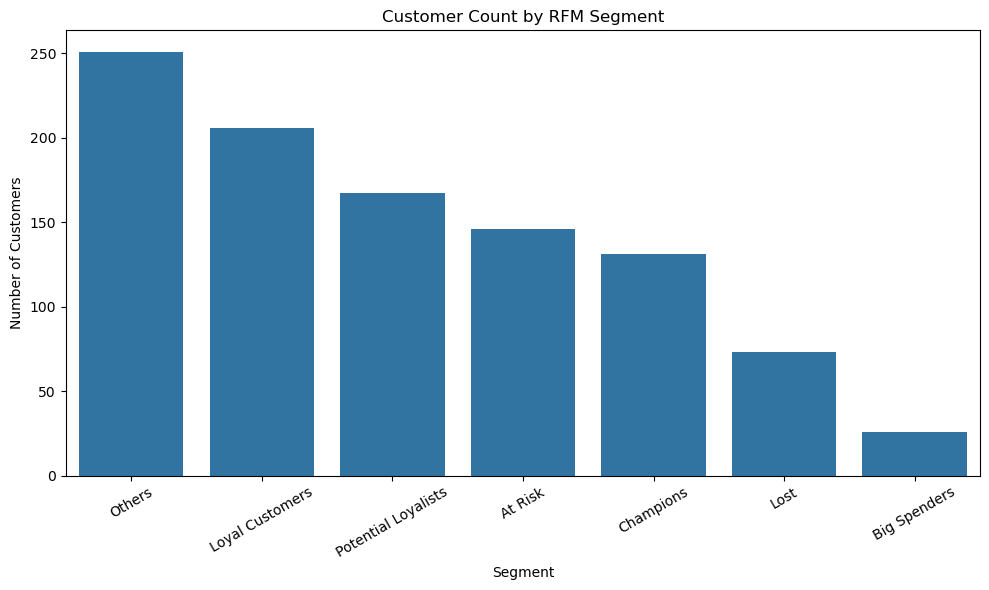

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
order = rfm["Segment"].value_counts().index
sns.countplot(data=rfm, x="Segment", order=order)
plt.title("Customer Count by RFM Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

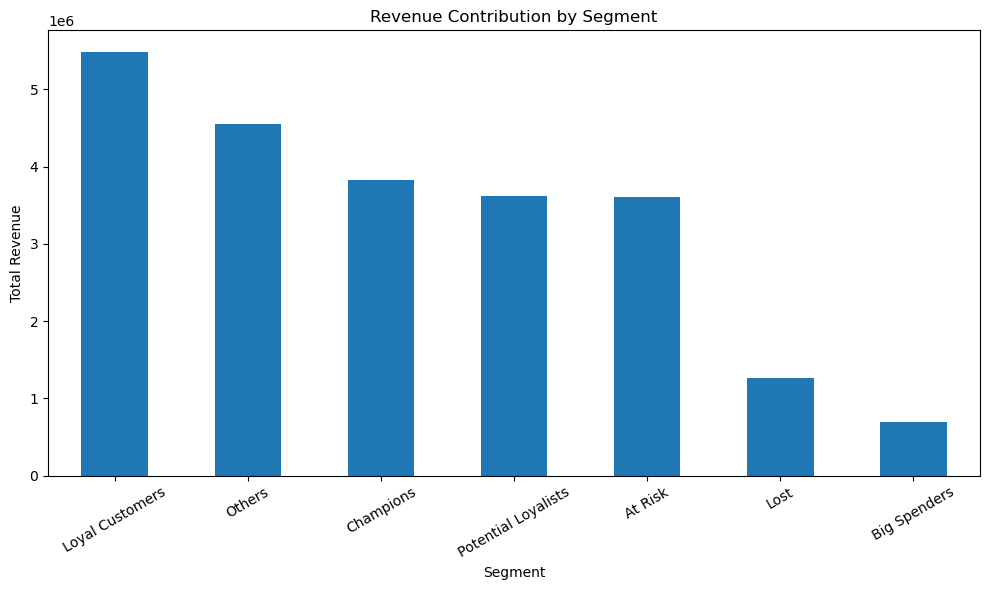

In [21]:
# Merge to get transaction amounts per customer segment
rfm_with_revenue = rfm.merge(df[["CustomerID", "TransactionAmount"]], on="CustomerID")

segment_revenue = (
    rfm_with_revenue
    .groupby("Segment")["TransactionAmount"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
segment_revenue.plot(kind="bar")
plt.title("Revenue Contribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

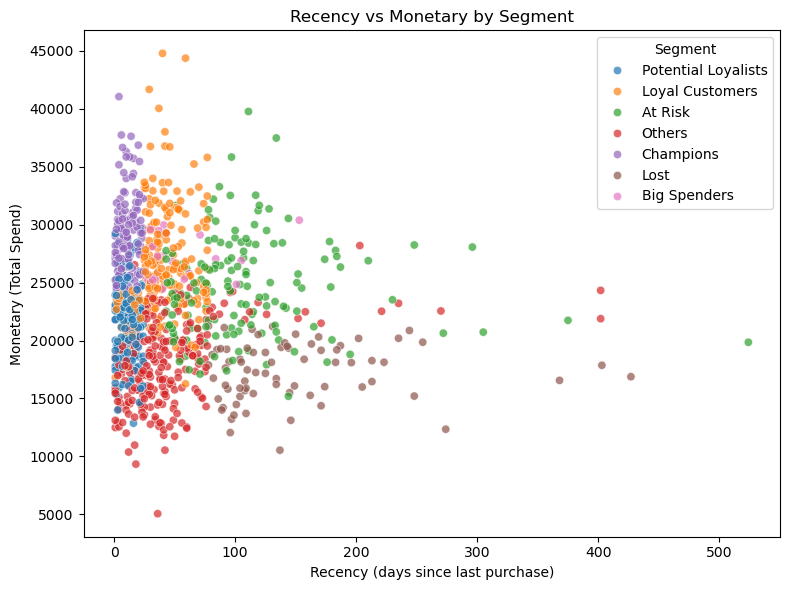

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Segment", alpha=0.7)
plt.title("Recency vs Monetary by Segment")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Monetary (Total Spend)")
plt.tight_layout()
plt.show()

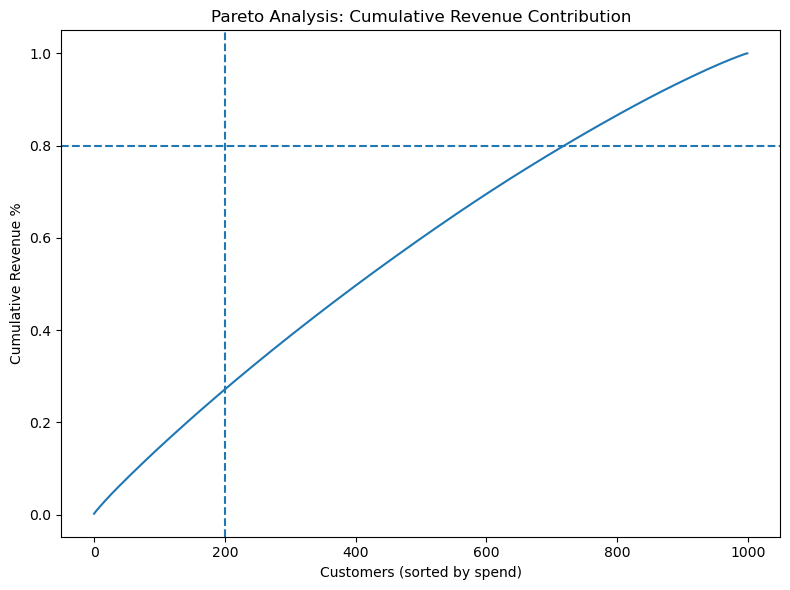

In [23]:
# Sort customers by Monetary value (descending)
rfm_sorted = rfm.sort_values("Monetary", ascending=False).reset_index(drop=True)

rfm_sorted["CumulativeRevenue"] = rfm_sorted["Monetary"].cumsum()
total_revenue = rfm_sorted["Monetary"].sum()
rfm_sorted["CumulativePerc"] = rfm_sorted["CumulativeRevenue"] / total_revenue

plt.figure(figsize=(8,6))
plt.plot(rfm_sorted["CumulativePerc"].values)
plt.axhline(0.8, linestyle="--")  # 80% line
plt.axvline(int(0.2 * len(rfm_sorted)), linestyle="--")  # 20% customers line
plt.title("Pareto Analysis: Cumulative Revenue Contribution")
plt.xlabel("Customers (sorted by spend)")
plt.ylabel("Cumulative Revenue %")
plt.tight_layout()
plt.show()


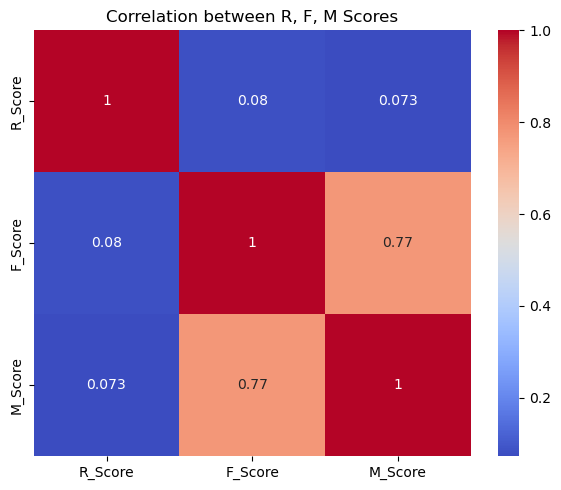

In [24]:
plt.figure(figsize=(6,5))
sns.heatmap(
    rfm[["R_Score", "F_Score", "M_Score"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation between R, F, M Scores")
plt.tight_layout()
plt.show()

# 📊 Insights

## 1. Customer Segmentation Overview
- Customers are segmented into Champions, Loyal Customers, Potential Loyalists, At Risk, Lost, Big Spenders, and Others.
- This segmentation converts raw transaction data into actionable business groups.

## 2. Champions & Loyal Customers Drive Revenue
- These customers buy frequently, recently, and spend more than average.
- They contribute a large share of total revenue.
- **Business Action:** Provide loyalty rewards, exclusive offers, and early access sales.

## 3. Big Spenders Are High-Value Customers
- Big Spenders spend a lot per purchase but may not buy very frequently.
- **Business Action:** Send personalized premium offers and encourage repeat purchases.

## 4. At Risk Customers Need Re-Engagement
- These customers used to buy often but haven’t purchased recently.
- **Business Action:** Run re-engagement campaigns, discounts, and win-back offers.

## 5. Lost Customers Have Low Business Value
- They buy rarely, spend little, and haven’t purchased in a long time.
- **Business Action:** Either try one last reactivation campaign or reduce marketing spend on them.

## 6. Pareto Principle (80/20 Rule)
- The Pareto analysis shows that a small percentage of customers contribute a large percentage of total revenue.
- This means retaining top customers is more profitable than only acquiring new ones.

## 7. Customer Behavior Pattern (Recency vs Monetary)
- Recent and high-spending customers are the most valuable.
- Old and low-spending customers are more likely to churn.
- **Business Action:** Focus marketing budget on high-value and at-risk valuable customers.


# 🏁 Conclusion

This project demonstrates how RFM (Recency, Frequency, Monetary) analysis can be used to:

- Clean and prepare customer transaction data
- Segment customers based on purchasing behavior
- Identify high-value customers and churn-risk customers
- Visualize important business patterns
- Generate actionable marketing insights

By using RFM-based segmentation, the company can:
- Improve targeted marketing campaigns
- Increase customer retention
- Optimize marketing spending
- Maximize revenue from high-value customers

Overall, this analysis shows that data-driven customer segmentation is a powerful approach for making better business decisions in the retail industry.
